In [1]:
import glob, os 
import salem
import numpy as np
import pandas as pd
import progressbar
import time
import tables
import rasterio
import xarray as xr
import warnings

In [2]:
gtd_f = os.path.expanduser('~/run_scripts/glathida_links/glathida-v3.1.0/data/TTT_per_rgi_id.h5')
out_f = os.path.expanduser('g2ti_vs_gtd_v3.1.0.h5')

In [3]:
with pd.HDFStore(gtd_f) as store:
    rgi_ids = list(store.keys())
rgi_ids = np.array([s[1:] for s in rgi_ids])
print(rgi_ids, len(rgi_ids))

['RGI60-01.00570' 'RGI60-01.08989' 'RGI60-01.10006' ... 'RGI60-19.02146'
 'RGI60-19.02147' 'RGI60-19.02150'] 2770


In [4]:
if os.path.exists(out_f):
    os.remove(out_f)

not_in_g2ti = []    
only_zeros = []    

for rid in progressbar.progressbar(rgi_ids):
    
    # Input files
    rgi_reg = rid[:8]
    f_mask = 'input_geometry/{}/{}/mask.tif'.format(rgi_reg, rid)
    f_thick = 'composite/{}/{}_thickness.tif'.format(rgi_reg, rid)
    # Ref thickness
    df = pd.read_hdf(gtd_f, rid)
    
    # Remove zero thickness
    df = df.loc[df['THICKNESS'] > 0]
    if len(df) == 0:
        only_zeros.append(rid)
        continue
    
    # Glacier map and mask
    try:
        ds = salem.GeoTiff(f_mask)
    except rasterio.RasterioIOError:
        not_in_g2ti.append(rid)
        continue
    grid = ds.grid
    mask = ds.get_vardata()
    
    # Transform and average points on grid map
    ii, jj = grid.transform(df['POINT_LON'], df['POINT_LAT'], crs=salem.wgs84, nearest=True)
    df['i'] = ii
    df['j'] = jj
    df['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
    df = df.loc[mask[jj, ii] == 1]
    gb = df.groupby('ij')
    dfm = gb.mean()
    dfm['SURVEY_DATE'] = gb.first()['SURVEY_DATE']
    dfm['REMARKS'] = gb.first()['REMARKS']
    dfm['i'] = dfm['i'].astype(int)
    dfm['j'] = dfm['j'].astype(int)
    dfm['N_POINTS'] = gb.count()['THICKNESS']
    
    # Composite
    with rasterio.open(f_thick) as ds:
        data = ds.read().squeeze()
        data[data < 0] = 0
        assert data.shape == mask.shape, 'Mask and thick do not match?'
    dfm['THICK_COMPOSITE'] = data[dfm['j'], dfm['i']] 
    
    # Individual models
    for model in ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']:
        f = f_thick.replace('composite', model).replace('_thickness.tif', '.tif').replace(rid, 'thickness_' + rid)
        try: 
            with rasterio.open(f) as ds:
                data = ds.read().squeeze()
                data[data < 0] = np.NaN
                assert data.shape == mask.shape, 'Mask and thick do not match? Model ' + model
            if rid == 'RGI60-11.03380':
                # corrupted file
                data[:, :3] = 0
            dfm['THICK_' + model.upper()] = data[dfm['j'], dfm['i']] 
        except rasterio.RasterioIOError:
            pass
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', tables.NaturalNameWarning)
        dfm.to_hdf(out_f, rid, append=True, complevel=5)

100% (2770 of 2770) |####################| Elapsed Time: 0:07:23 Time:  0:07:23


In [8]:
len(only_zeros), len(not_in_g2ti) # pd.read_hdf(gtd_f, only_zeros[0])

(1037, 116)

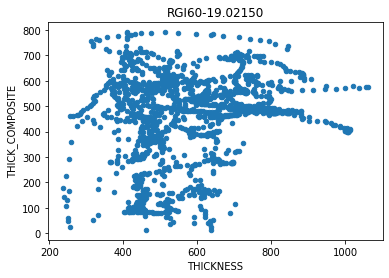

In [12]:
dfm.plot(kind='scatter', x='THICKNESS', y='THICK_COMPOSITE', title=rid);

In [13]:
with pd.HDFStore(out_f) as store:
    rgi_ids = list(store.keys())
rgi_ids = np.array([s[1:] for s in rgi_ids])
print(rgi_ids, len(rgi_ids))

['RGI60-01.00570' 'RGI60-01.08989' 'RGI60-01.10006' ... 'RGI60-19.01435'
 'RGI60-19.01443' 'RGI60-19.01721'] 1615


In [16]:
svalbard = [s for s in rgi_ids if 'RGI60-07' in s]

In [40]:
len(svalbard)

200

## Get the ones that entered in g2ti 

In [32]:
dfg = pd.read_csv('./zip/g2ti_data/INDEX_thickness_data.csv', index_col=0)
dfg = dfg.loc[dfg.n_pts > 0]

In [35]:
sval_old = [s for s in dfg.index if 'RGI60-07' in s]

In [38]:
len(sval_old), sval_old

(8,
 ['RGI60-07.00027',
  'RGI60-07.00028',
  'RGI60-07.00408',
  'RGI60-07.00409',
  'RGI60-07.00427',
  'RGI60-07.00428',
  'RGI60-07.00429',
  'RGI60-07.00434'])

In [55]:
cant_use = np.append(dfg.index, svalbard)
cant_use.sort()
cant_use = np.unique(cant_use)

In [58]:
keep_for_comp = [s for s in rgi_ids if s not in cant_use]

In [60]:
len(keep_for_comp)

651

In [65]:
df = pd.read_hdf(out_f, keep_for_comp[1])
df

GlaThiDa_ID  POINT_LAT   POINT_LON   THICKNESS  \
ij                                                          
0179_0064       6578.0  61.215660 -148.278015  207.000000   
0180_0064       6578.0  61.215517 -148.277389  209.000000   
0180_0065       6578.0  61.215327 -148.276543  214.000000   
0181_0065       6578.0  61.215040 -148.275284  222.000000   
0182_0065       6578.0  61.214701 -148.273814  232.666667   
...                ...        ...         ...         ...   
0217_0088       6578.0  61.194525 -148.207779  269.500000   
0217_0089       6578.0  61.194431 -148.206871  252.000000   
0218_0089       6578.0  61.194303 -148.205505  236.500000   
0219_0089       6578.0  61.194155 -148.203670  212.250000   
0220_0089       6578.0  61.194073 -148.202530  184.000000   

           THICKNESS_UNCERTAINTY  DATA_FLAG    i   j SURVEY_DATE  \
ij                                                                 
0179_0064                   35.0        NaN  179  64    20120316   
0180_0064                   35.0        NaN  180  64    20120316   
0180_0065                   35.0        NaN  180  65    20120316   
0181_0065                   35.0        NaN  181  65    20120316   
0182_0065                   35.0        NaN  182  65    20120316   
...                          ...        ...  ...  ..         ...   
0217_0088                   35.0        NaN  217  88    20120316   
0217_0089                   35.0        NaN  217  89    20120316   
0218_0089                   35.0        NaN  218  89    20120316   
0219_0089                   35.0        NaN  219  89    20120316   
0220_0089                   35.0        NaN  220  89    20120316   

                     REMARKS  N_POINTS  THICK_COMPOSITE  THICK_MODEL_1  \
ij                                                                       
0179_0064                NaN         1       323.695862     277.737274   
0180_0064                NaN         2       325.509583     275.397949   
0180_0065                NaN         2       310.012573     264.483704   
0181_0065  Medium confidence         4       317.642670     275.516571   
0182_0065  Medium confidence         3       322.953949     284.768982   
...                      ...       ...              ...            ...   
0217_0088  Medium confidence         2       293.102081     229.699097   
0217_0089  Medium confidence         2       294.914307     226.862732   
0218_0089  Medium confidence         4       297.420502     222.913849   
0219_0089                NaN         4       298.051147     217.444626   
0220_0089                NaN         1       293.821716     213.515594   

           THICK_MODEL_2  THICK_MODEL_3  
ij                                       
0179_0064     339.375031     365.799072  
0180_0064     339.045227     375.246582  
0180_0065     314.403290     363.704926  
0181_0065     316.495758     372.924713  
0182_0065     312.969452     382.684052  
...                  ...            ...  
0217_0088     340.816406     323.133881  
0217_0089     346.199158     327.070404  
0218_0089     357.561249     328.334229  
0219_0089     365.639923     328.781036  
0220_0089     357.279358     328.609070  

[65 rows x 15 columns]

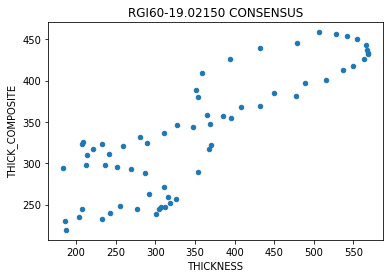

In [66]:
df.plot(kind='scatter', x='THICKNESS', y='THICK_COMPOSITE', title=rid + ' CONSENSUS');

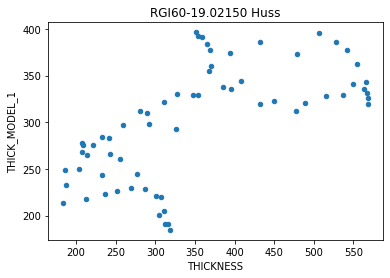

In [67]:
df.plot(kind='scatter', x='THICKNESS', y='THICK_MODEL_1', title=rid + ' Huss');

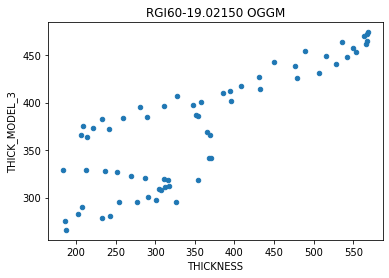

In [68]:
df.plot(kind='scatter', x='THICKNESS', y='THICK_MODEL_3', title=rid + ' OGGM');